# Exercício de análise e seleção de modelos de regressão linear

Como pessoa Cientista de Dados, você está encarregada pela análise do problema de precificação de quartos de hotéis, fazendo uso do conjunto de dados fornecidos. Para isso, você dispõe desse dataset.

Nesta atividade, sua tarefa envolve conduzir as seguintes etapas:

- análise inicial com o PairPlot da Seaborn;
- construir modelos de regressão linear; e
- realizar a comparação desses modelos.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy.stats import probplot

## Importando os Dados

In [3]:
df = pd.read_csv("hoteis.csv")
df.head()

,Estrelas,ProximidadeTurismo,Capacidade,Preco
0,5,9.301565,3,506.275452
1,1,1.785891,1,246.363458
2,4,15.504293,3,325.873550
3,4,4.173188,3,521.343284
4,4,9.443685,1,252.587087


## Conhecendo os Dados

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Estrelas            1000 non-null   int64  
 1   ProximidadeTurismo  1000 non-null   float64
 2   Capacidade          1000 non-null   int64  
 3   Preco               1000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 31.4 KB


In [5]:
df.describe()

,Estrelas,ProximidadeTurismo,Capacidade,Preco
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.008000,7.650878,2.519000,396.611361
std,1.407095,5.870137,1.108543,171.742433
min,1.000000,0.013850,1.000000,-220.208705
25%,2.000000,3.034775,2.000000,283.590980
50%,3.000000,6.430035,3.000000,401.743527
75%,4.000000,10.863295,4.000000,516.097856
max,5.000000,31.709748,4.000000,836.261308


Pode-se observar os seguintes fatores sobre o dataset de hotéis:
- 1000 listagens.
- Média de capacidade de 2 a 3 pessoas.
- Média de 7.65Km de proximidade de pontos turísticos.
- Capacidades variando de 1 a 4 pessoas.
- Distâncias de pontos turísticos variando de 100m a 32Km.
- Estrelas variando de 1 a 5, com uma média de 3.
- Preço de hospedagens com média de R$396,61.
- Variação de preço de -220 a 836. Indicando sujeira no dataset.


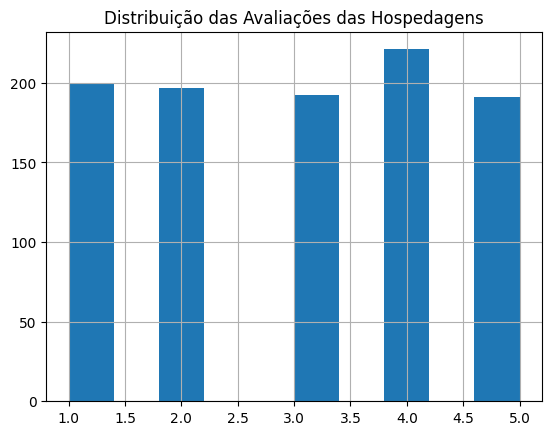

In [6]:
df.Estrelas.hist()
plt.title('Distribuição das Avaliações das Hospedagens')
plt.show()

Observa-se uma distribuição bem equilibrada das avaliações dos hotéis.

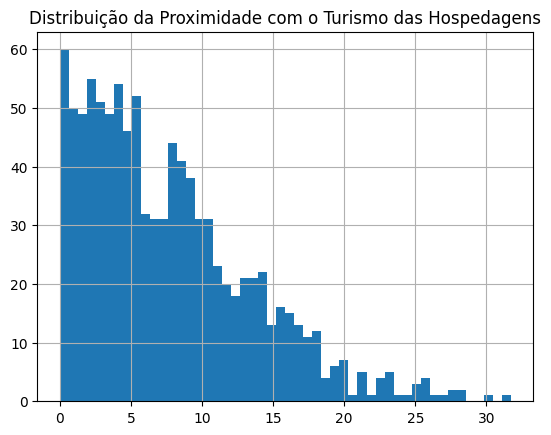

In [7]:
df.ProximidadeTurismo.hist(bins=50)
plt.title('Distribuição da Proximidade com o Turismo das Hospedagens')
plt.show()

Vemos a Proximidade com Turísmo mais concentrada em distâncias menores dos pontos de interesse do que distantes dos mesmos.

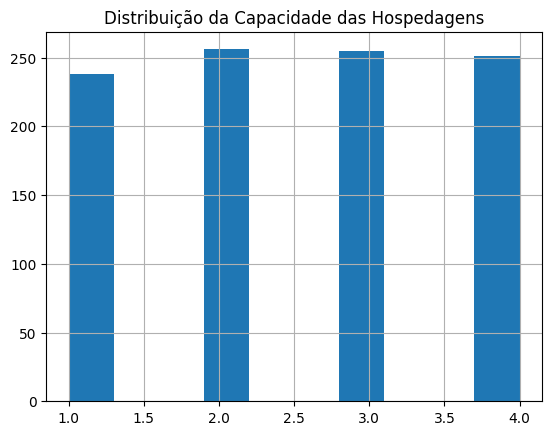

In [8]:
df.Capacidade.hist()
plt.title('Distribuição da Capacidade das Hospedagens')
plt.show()

Novamente vemos um gráfico de distribuição bem equilibrado. Porém podemos notar que hospedagens com capacidade para 1 pessoa são as menos frequentes.

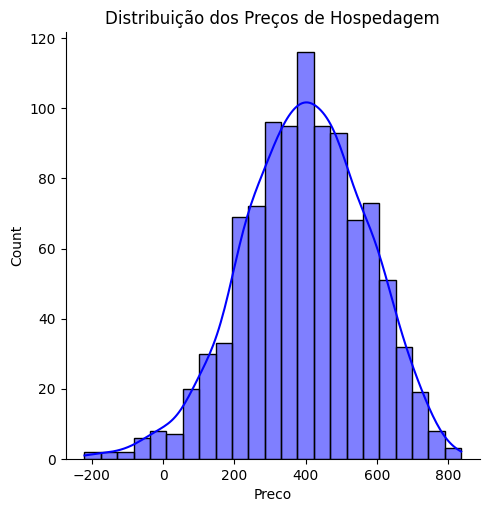

In [9]:
sns.displot(df.Preco, kde=True, color="blue")
plt.title('Distribuição dos Preços de Hospedagem')
plt.show()

Pode-se observar que o preço médio das hospedagens gira em torno de R$400, com uma distribuição seguindo um padrão normal.

Porém podemos também ver que há valores negativos no dataset. Considerando que hospedagens não costumam pagar para os hóspedes frequentarem seus estabelicimentos, vamos transformar os valores negativos em positivos.

## Limpando os dados

In [10]:
df.Preco = df.Preco.apply(lambda x: np.abs(x) if x < 0 else x)

In [11]:
print("Preço Min: ", df.Preco.min())
print("Preço Max: ", df.Preco.max())

Preço Min:  1.6057343397926471
Preço Max:  836.2613078967568


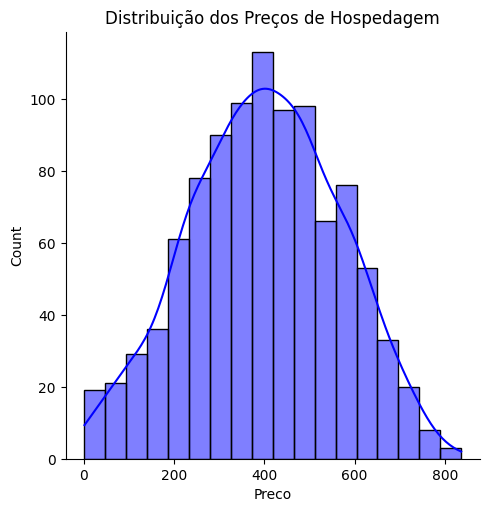

In [12]:
sns.displot(df.Preco, kde=True, color="blue")
plt.title('Distribuição dos Preços de Hospedagem')
plt.show()

Considerando-se que estamos falando de hospedagens e estamos em 2025. E que mesmo, por exemplo, 15 anos atrás pagar menos que R$20 numa diária já era quase impossível. Vamos ver quantos valores temos abaixo de R$20 e analisar se devemos deixá-los no dataset ou não.

In [13]:
df.Preco[df.Preco < 20]

46      1.605734
126     7.268904
137     9.364953
180    12.168455
229    13.951666
561     5.397100
753    11.603584
804    10.714595
833    15.609632
Name: Preco, dtype: float64

Como são poucos os valores abaixo de R$20, decido por removê-los do dataset.

In [14]:
df.drop(df.Preco[df.Preco < 20].index, axis=0, inplace=True)

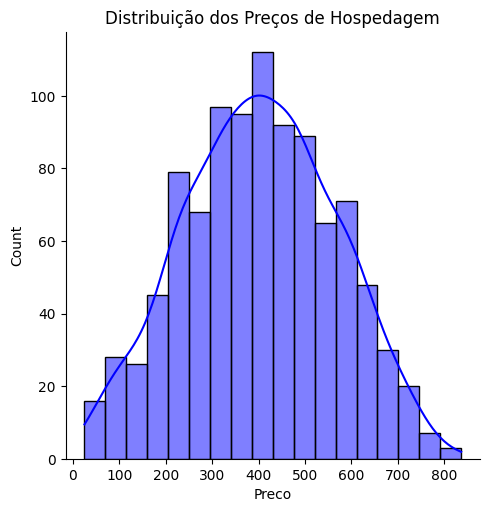

In [15]:
sns.displot(df.Preco, kde=True, color="blue")
plt.title('Distribuição dos Preços de Hospedagem')
plt.show()

Podemos ver pelo gráfico acima que agora não temos valores muito próximos de zero na coluna de Preços.

## Correlacionando Características das Hospedagens

Com o intuito de criar um modelo de predição de preço de hospedagens com o dataset aqui em contexto, precisamos analisar a correlação entre as propriedades(colunas) que formam o dataset buscando as que possuem maior relação entre si. Estas propriedades são as que devemos utilizar para treinar nosso modelo.

In [16]:
corr = df.corr()
corr

,Estrelas,ProximidadeTurismo,Capacidade,Preco
Estrelas,1.000000,0.005865,-0.027189,0.409628
ProximidadeTurismo,0.005865,1.000000,-0.009940,-0.665429
Capacidade,-0.027189,-0.009940,1.000000,0.528804
Preco,0.409628,-0.665429,0.528804,1.000000


Note que com uma tabela de correlação, podemos focar apenas nos valores do triângulo inferior.

Vamos criar um heatmap para facilitar a interpretação da tabela.

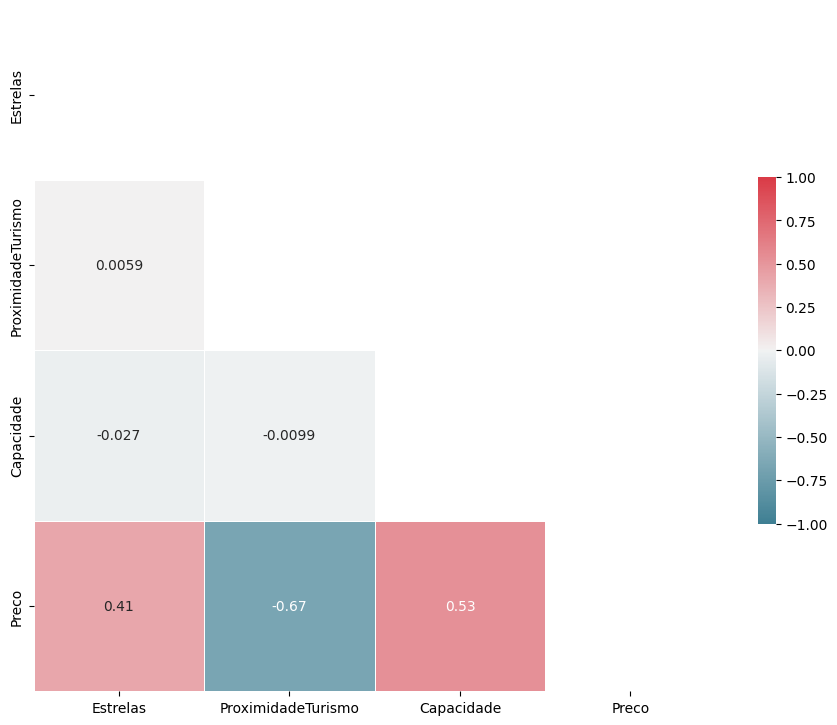

In [17]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.show()

Podemos observar que:
- Proximidade com o Turismo, Capacidade e Estrelas não possuem correlação significativa entre si.
- Preço e Estrelas(.41) e Preço e Capacidade(.53) apresentam correlações moderadas.
- Preço e Proximidade com o Turismo apresentam a maior correlação, -0.67, sendo uma correlação negativa, quanto mais próxima do turismo, mais cara tende a ser a hospedagem.

## Gerando modelos lineares

### Modelo considerando apenas Proximidade com Turismo

In [22]:
xtrain_pt, xtest_pt, ytrain_pt, ytest_pt = train_test_split(df.drop(columns="Preco"), df['Preco'], test_size=0.3, random_state=230)

In [23]:
dftrain_pt = pd.DataFrame(data=xtrain_pt)
dftrain_pt["Preco"] = ytrain_pt

In [24]:
model_pt = ols("Preco ~ ProximidadeTurismo", data = dftrain_pt).fit()

In [25]:
print(model_pt.summary())

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     555.6
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           1.34e-90
Time:                        07:11:31   Log-Likelihood:                -4310.6
No. Observations:                 693   AIC:                             8625.
Df Residuals:                     691   BIC:                             8634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            544.4526      7

Vemos um intercepto de 544.45, indicando o preço esperado da pousada caso a variável independente seja 0. E temos uma variável independente com coeficiente negativo -18.91, indicando que para cada quilometro adicionado à distância da pousada de um centro turístico, o valor da hospedagem tende a diminuir.

Porém, nota-se que o R² mostra uma explicabilidade de apenas 0.445 no valor da hospedagem.

Vamos checar os resíduos deste modelo:

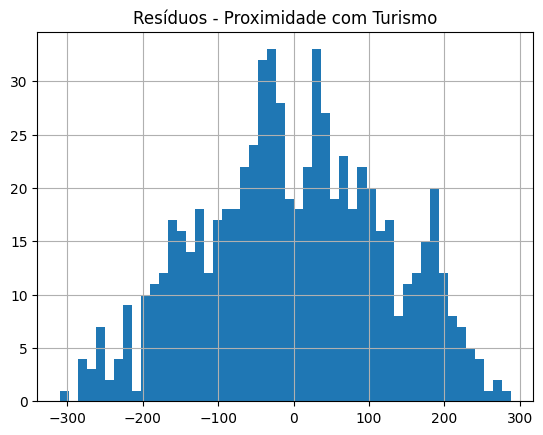

In [26]:
model_pt.resid.hist(bins=50)
plt.title("Resíduos - Proximidade com Turismo")
plt.show()

Vemos que os resíduos aqui se comportam relativamente como uma normal, se agrupando em torno de 0, representando que a linha da regressão divide relativamente bem os valores da distribuição ProximidadeTurismo x Preço.

Podemos usar o gráfico "probplot" do scipy.stats para ter uma visão dos resíduos organizados em quantis e distribuidos ao longo de uma reta. Neste gráfico procuramos ver a maioria dos pontos distribuidos quase exatamente sobre a reta, o que indicaria que os resíduos realmente se comportam como uma normal.

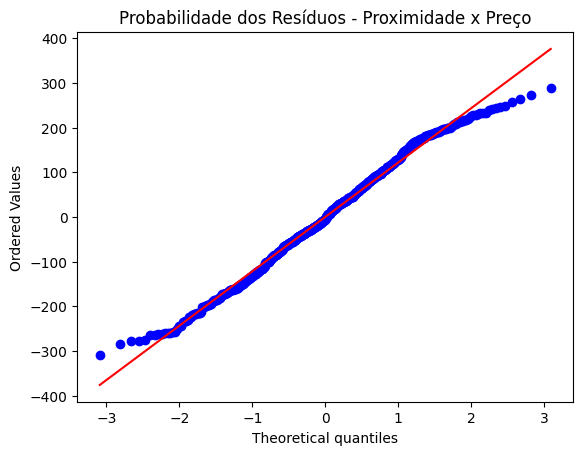

In [31]:
(_, (_,_,_)) = probplot(model_pt.resid, plot = plt)
plt.title("Probabilidade dos Resíduos - Proximidade x Preço")
plt.show()

Note como os valores seguem a reta entre os quantis (-2,2). Veja que tais valores batem com uma quebra de padrão brusca no histograma visto acima nos valores -200 e 200.

De qualquer forma, podemos ainda considerar estes resíduos como se comportando como uma normal. Só precisamos ter em mente que a explicabilidade do modelo foi de apenas 44%.

Vejamos agora a explicabilidade sobre os dados de teste.

In [32]:
y_predict = model_pt.predict(xtest_pt)
print("R²: ", r2_score(ytest_pt, y_predict))

R²:  0.4352423007738909


Vemos um valor bem próximo da explicabilidade vista sobre os dados de treino. Indicando que o modelo está se comportando como esperado, que não há, aparentemente, nenhum viés nos dados utilizados até agora.

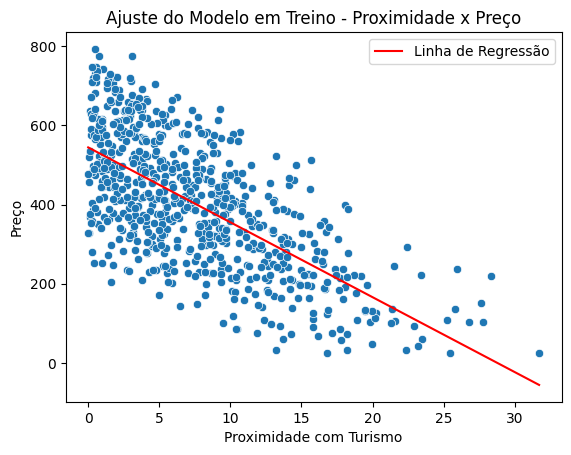

In [36]:
sns.scatterplot(data=dftrain_pt, x = "ProximidadeTurismo", y = "Preco")

x_range = np.linspace(dftrain_pt['ProximidadeTurismo'].min(), dftrain_pt['ProximidadeTurismo'].max(), 100)
y_pred = model_pt.predict(pd.DataFrame({"ProximidadeTurismo": x_range}))
plt.plot(x_range, y_pred, color="red", label="Linha de Regressão")

plt.title("Ajuste do Modelo em Treino - Proximidade x Preço")
plt.xlabel("Proximidade com Turismo")
plt.ylabel("Preço")
plt.legend()
plt.show()

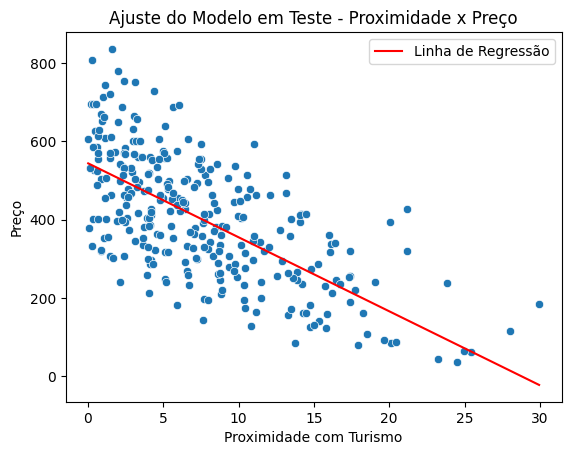

In [37]:
dftest_pt = pd.DataFrame(data=xtest_pt)
dftest_pt["Preco"] = ytest_pt

sns.scatterplot(data=dftest_pt, x = "ProximidadeTurismo", y = "Preco")

x_range = np.linspace(dftest_pt['ProximidadeTurismo'].min(), dftest_pt['ProximidadeTurismo'].max(), 100)
y_pred = model_pt.predict(pd.DataFrame({"ProximidadeTurismo": x_range}))
plt.plot(x_range, y_pred, color="red", label="Linha de Regressão")

plt.title("Ajuste do Modelo em Teste - Proximidade x Preço")
plt.xlabel("Proximidade com Turismo")
plt.ylabel("Preço")
plt.legend()
plt.show()

### Modelo considerando Proximidade e Capacidade